#### In this notebook, models are compared, best model/s is/are used to predict target values. 

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import joblib
import os

In [2]:
# get models form ../models/ file

In [3]:
raw_path = "../models/"
models_list = os.listdir(raw_path)
models_path_dict = {}

for model in models_list:
    path = os.path.join(raw_path, model)
    models_path_dict.update({model: path})

In [4]:
models_path_dict

{'KNN': '../models/KNN',
 'LR': '../models/LR',
 'RFF': '../models/RFF',
 'SVM': '../models/SVM',
 'XGBC': '../models/XGBC'}

In [5]:
# load models and keep them in dict

In [6]:
models_obj_dict = {}
for model, path in models_path_dict.items():
    model_obj = joblib.load(path)
    models_obj_dict.update({model: model_obj})

### Data preparation

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

input_data = pd.read_csv("../data/processed/Graduate - IRISES dataset (2019-06)_READY_TO_TRAIN.csv", sep="|")
target_values = input_data["Species"]
predictors = input_data.drop("Species", axis=1)
X_train, X_test, y_train, y_test = train_test_split(predictors, target_values, test_size=0.30, random_state=101)

### Models evaluation

In [8]:
models_metrics = []
models_names = []

In [9]:
# Get basic metrics such as: f1, recall, precision, cross-validation and area under ROC

In [10]:
for model_name, model in models_obj_dict.items():

        predicted = model.predict(X_test)
        predicted_p = model.predict_proba(X_test)
        
        report = classification_report(y_test, predicted)
        
        cv = cross_val_score(model, X_train, y_train, cv=5)
        roc_auc_s = roc_auc_score(y_test, predicted_p, multi_class="ovo")
        
        metrics = [report, cv, roc_auc_s]
        models_metrics.append(metrics)
        models_names.append(model_name)

In [11]:
models_metrics_dict = dict(zip(models_names, models_metrics))

### Models comparison

In [32]:
file = open("../reports/General Models Metrics.md", "w")
for model, metrics in models_metrics_dict.items():
    file.write("*"*60)
    file.write("\n{}".format(model_name))
    file.write("\n{}".format(metrics[0]))
    file.write("\nArea Under the ROC: {}\n".format(metrics[2]))

file.close()

#### Get data about distribution of cv-scores

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
sns.set(rc={'figure.figsize':(12,9)})

In [15]:
cv_matrix = np.zeros(shape=(5,5))
for column, model in enumerate(models_names):
    cv_values = models_metrics_dict.get(model)[1] # Cross validation values
    print(model)
    print(cv_values)
    cv_matrix[column] = cv_values

SVM
[0.95238095 0.95238095 1.         0.95238095 0.95      ]
XGBC
[1.         0.95238095 1.         0.95238095 0.9       ]
RFF
[1.         0.95238095 1.         0.95238095 0.9       ]
LR
[1.         0.95238095 1.         0.95238095 0.9       ]
KNN
[1.         0.95238095 1.         1.         0.95      ]


In [16]:
cv_matrix = cv_matrix.T

In [17]:
cv_data = pd.DataFrame(cv_matrix, columns=models_names)

In [18]:
cv_data

,SVM,XGBC,RFF,LR,KNN
0,0.952381,1.000000,1.000000,1.000000,1.000000
1,0.952381,0.952381,0.952381,0.952381,0.952381
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.952381,0.952381,0.952381,0.952381,1.000000
4,0.950000,0.900000,0.900000,0.900000,0.950000


In [19]:
cv_data.describe()

,SVM,XGBC,RFF,LR,KNN
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.961429,0.960952,0.960952,0.960952,0.980476
std,0.021587,0.041568,0.041568,0.041568,0.026747
min,0.950000,0.900000,0.900000,0.900000,0.950000
25%,0.952381,0.952381,0.952381,0.952381,0.952381
50%,0.952381,0.952381,0.952381,0.952381,1.000000
75%,0.952381,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
cv_data.describe().to_html("../reports/figures/descriptive statistics_cross_val_scores.html")

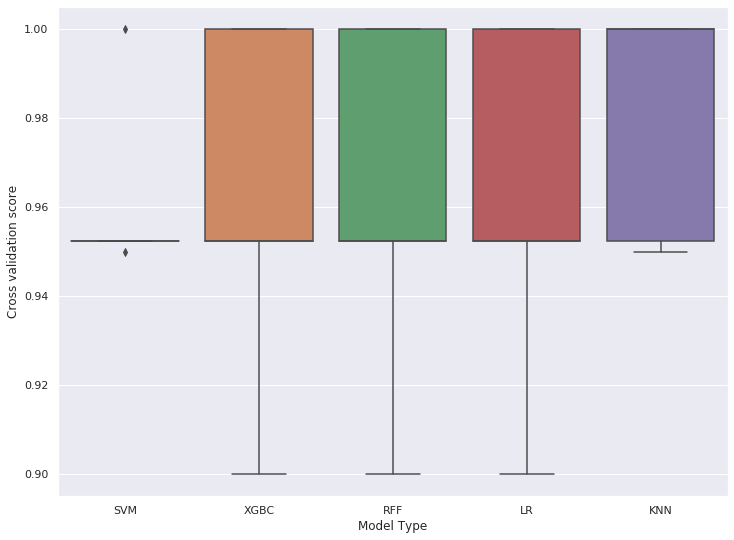

In [21]:
box_plot = sns.boxplot(data=cv_data)
box_plot.set(xlabel="Model Type", ylabel="Cross validation score")
box_plot.figure.savefig("../reports/figures/box_plot_cross_validation_scores.png")

### Test hypothesis that median/mean of all of the groups are equal, with level of significance = 0.05

In [22]:
from scipy import stats

#### Test normal distribution using Shapiro-Wilk Test

In [23]:
for model_cv in cv_data.columns:
    p_val = stats.shapiro(cv_data[model_cv])[1]
    if p_val <= 0.05:
        print("Distribution of {} is NOT CONSISTENT with normal distribution, p-val: {}".format(model_cv, p_val))
    else:
        print("Distribution of {} is consistent with normal distribution, p-val: {}".format(model_cv, p_val))

Distribution of SVM is NOT CONSISTENT with normal distribution, p-val: 0.0004962262464687228
Distribution of XGBC is consistent with normal distribution, p-val: 0.30614763498306274
Distribution of RFF is consistent with normal distribution, p-val: 0.30614763498306274
Distribution of LR is consistent with normal distribution, p-val: 0.30614763498306274
Distribution of KNN is NOT CONSISTENT with normal distribution, p-val: 0.009351502172648907


In [24]:
# Because not all distributions are consistent with the normal distribution, nonparametric tests were used

#### Test the null hypothesis that the population median of all of the groups are equal using Kruskal-Wallis test

In [25]:
from itertools import combinations

In [26]:
pair_to_compare = list(combinations(cv_data.columns, 2))

In [27]:
for model_a, model_b in pair_to_compare:
    p_val = stats.kruskal(cv_data[model_a], cv_data[model_b])[1]
    if p_val <= 0.05:
        print("Median of cross validation score is different between {} x {}".format(model_a, model_b))
    else:
        print("Median of cross validation score is NO DIFFERENT between {} x {}".format(model_a, model_b))

Median of cross validation score is NO DIFFERENT between SVM x XGBC
Median of cross validation score is NO DIFFERENT between SVM x RFF
Median of cross validation score is NO DIFFERENT between SVM x LR
Median of cross validation score is NO DIFFERENT between SVM x KNN
Median of cross validation score is NO DIFFERENT between XGBC x RFF
Median of cross validation score is NO DIFFERENT between XGBC x LR
Median of cross validation score is NO DIFFERENT between XGBC x KNN
Median of cross validation score is NO DIFFERENT between RFF x LR
Median of cross validation score is NO DIFFERENT between RFF x KNN
Median of cross validation score is NO DIFFERENT between LR x KNN
